In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

This notebook shows how supply sensitive routing works using a randomly generated graph. The core concepts are outlined in the associated paper. In this notebook, a random graph containing places and stations is generated. First a generic example is given where routing is done purely to minimize travel time. Second, a case including vehicle and station parameters is generated and run.

In [2]:
'''
Creating a random graph

graph contains n places and m charging stations - the random graph is completely connected
'''
deep_reload(src)

# Parameters for graph creation
seed = 125396749 # RNG seed [-]
n = 15 # Number of places [-]
m = 85 # Number of stations [-]
speeds = [105 / 3.6] # Set of speeds to be assigned to links [m/s]
chargers = list(range(10)) # Set of numbers of chargers to be assigned to stations [-]
scale = (1e6, 1e6) # Scale of the area on which the graph is generated ([m], [m])

# Setting the graph as directed
kw = {
    'graph': {
        'directed': True,
    },
}

# Creating the graph
graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers, **kw
)

# Marking the edge types by source and target type
graph = src.routing.edge_types(graph)

In [3]:
'''
Running with Bellman with default objective

This cell uses a simple objective function which minimizes travel time but limits
the travel time of edge which can be traversed forcing indirect routes in some cases.
This is a fairly limiting cost function which, more or less mimics the NetworkX
implementation.
'''
deep_reload(src)

# Selecting the origin - this must be an iterable. Multiple origins can be selected.
origins = ['place_0']

# Defining the cost function
objective = src.routing.Objective(field = 'time', edge_limit = 3600 * 3)

t0 = time.time()

# Running the optimization
costs, values, paths = src.routing.shortest_paths(
    graph, origins,
    objective = objective,
    return_paths = True,
    method = 'dijkstra'
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0036 seconds


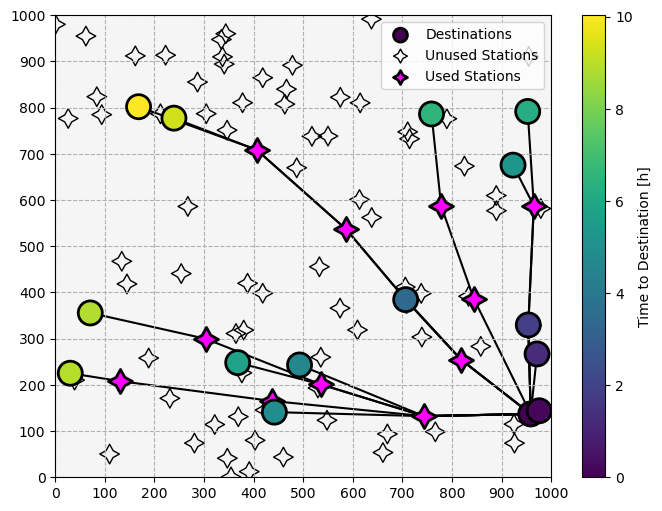

In [4]:
'''
Plotting the optimal paths
'''
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'place']

kw = src.figures.default_route_tree_kwargs

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'place'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [5]:
'''
Running routing optimization using Vehicle and Station object parameters.

These are the objects used in the paper. The Vehicle object is analogous to Objective.
Vehicle and Station are used to add estimations of resupply time to edges. This works
as follows:

The waiting time is estimated at each node - first the number of usable chargers is
sampled based on the reliability parameter, next the waiting time is expected using
a variety of parameters.

The charging time is computed for the vehicle at the start node and added to the 
waiting time at the start node.

In this cell, the Vehicle and Station parameters are generated as in the random experiment.
'''

deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

vehicle_param = src.experiments._vehicle_kwargs
station_param = src.experiments._station_kwargs
graphs = [0]

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng,
)

In [6]:
'''
Running the case as generated (computes all pairs shortest paths)
'''
deep_reload(src)

t0 = time.time()

costs, values, paths = src.experiments.run_case(
    graph, vehicle_kw, station_kw, method = 'dijkstra'
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.9498 seconds


In [7]:
'''
Computing impedances
'''
deep_reload(src)

print(src.routing.impedance(values, field = 'total_time') / 3600)

print(src.routing.impedance(values, field = 'driving_time') / 3600)

6.224593230924332
5.201706912016359


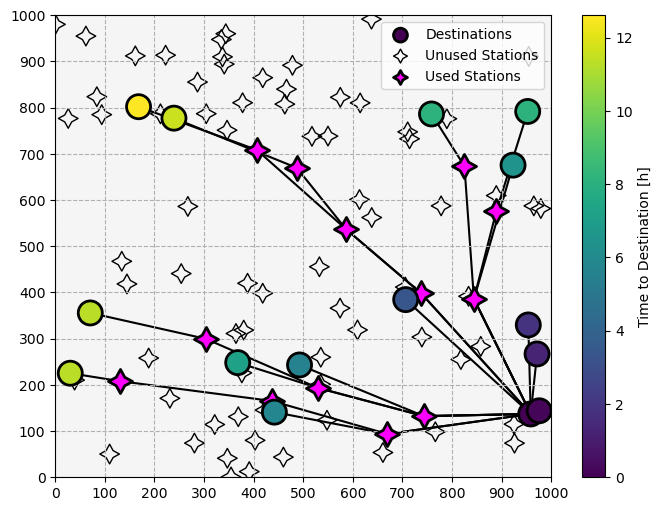

In [8]:
'''
Plotting the optimal paths
'''
deep_reload(src)

origin = 'place_0'

fig, ax = plt.subplots(figsize = (8, 6))

places = [k for k, v in graph._node.items() if v['type'] is 'place']

kw = src.figures.default_route_tree_kwargs

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v['total_time'].mean() / 3600 for k, v in values[origin].items()},
    paths = {k: v for k, v in paths[origin].items() if graph._node[k]['type'] is 'place'},
    destinations = places,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')